# Things to try next

Working with (hand-annotated) RAS guidance document corpus

## Encodings and summarizing the data

1. tf-idf *on each snippet* (`mcrt-demo.ipynb` considers aggregating by guidance doc)
    - on each *sentence*?
2. BoW *on each snippet*
3. compare tf-idf/BoW to "frequencies" from content analysis (what is value added)?
4. beyond tf-idf/BoW: word2vec? other embeddings?

## Beyond encodings

1. Document similarity
2. Unsupervised learning: Clustering? What patterns emerge? (off the shelf)
2. Classification (off the shelf)
3. Coreference resolution and NER (harder) (off the shelf, evaluate how bad it is)
4. Topic modeling (off the shelf)
5. Sentiment analysis?
5. Queries?

In [1]:
# load packages
import pandas as pd
import numpy as np
import string
import re
import nltk

In [2]:
nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag

nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package punkt to /Users/jff/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jff/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/jff/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from gensim import corpora, models, similarities, downloader

## Load data

In [4]:
# path to RAS corpus
path_ras = '../data/processed/corpus_guidance.csv'

In [5]:
df = pd.read_csv(path_ras)
df.head(5)

,unique_id,snippet,tag_0,tag_1,tag_2,source,group
0,0,NaN,GUIDE PURPOSE AND OBJECTIVES,NaN,NaN,A1 - Plan Alignment Compass_Combined,Climate Adaptation
1,1,NaN,COMMUNITY GOAL SETTING AND COORDINATION,NaN,NaN,A1 - Plan Alignment Compass_Combined,Climate Adaptation
2,2,"Quality public engagement is essential, and so...",COMMUNITY GOAL SETTING AND COORDINATION,Stakeholder Involvement (general),NaN,A1 - Plan Alignment Compass_Combined,Climate Adaptation
3,3,Local agency champions are neededbecome one! D...,COMMUNITY GOAL SETTING AND COORDINATION,Stakeholder Groups (specific),Local Intra-governmental,A1 - Plan Alignment Compass_Combined,Climate Adaptation
4,4,Equity and environmental justice must be consi...,COMMUNITY GOAL SETTING AND COORDINATION,Community Goals Identification,NaN,A1 - Plan Alignment Compass_Combined,Climate Adaptation


In [6]:
# dimensions
df.shape

(3014, 7)

In [7]:
# drop rows with NaN snippet
df = df[df['snippet'].notna()]
df.shape

(2866, 7)

In [8]:
# how many snippets un-ocr'd?
3014-2866

148

In [9]:
# count unique tags per level
print('How many tags at each level?')
df.tag_0.nunique(), df.tag_1.nunique(), df.tag_2.nunique()

How many tags at each level?


(7, 18, 30)

In [10]:
# count tag occurrence in each tag level
print('Tag occurrence by level:\n')
print('tag_0:\n', df['tag_0'].value_counts(), '\n')
print('tag_1:\n', df['tag_1'].value_counts(), '\n')
print('tag_2:\n', df['tag_2'].value_counts(), '\n')

Tag occurrence by level:

tag_0:
 STRATEGY IDENTIFICATION                    787
COMMUNITY GOAL SETTING AND COORDINATION    718
FACT BASE                                  470
ANALYSIS METHODS                           389
IMPLEMENTATION AND MONITORING              312
GUIDE PURPOSE AND OBJECTIVES               188
Unsure - Discuss                             2
Name: tag_0, dtype: int64 

tag_1:
 Strategy Actions (specific)          578
Current & Future Data (specific)     368
Analysis Methods                     330
Stakeholder Groups (specific)        193
Stakeholder Involvement (general)    150
Implementation                       135
Community Goals Identification       134
Planning Team Members (specific)     130
Strategy Selection                   127
Evaluation and Monitoring             87
Guide Purpose Statement               64
Term definition                       49
Plan Compliance and Integration       45
Planning Team (general)               44
Guide Outcomes             

In [11]:
# count labels
print('Label ("group") counts:\n')
print(df['group'].value_counts(), '\n')

Label ("group") counts:

Climate Adaptation                  1207
Resilience and Hazard Mitigation    1111
Sustainability                       548
Name: group, dtype: int64 



<AxesSubplot:xlabel='tag_0'>

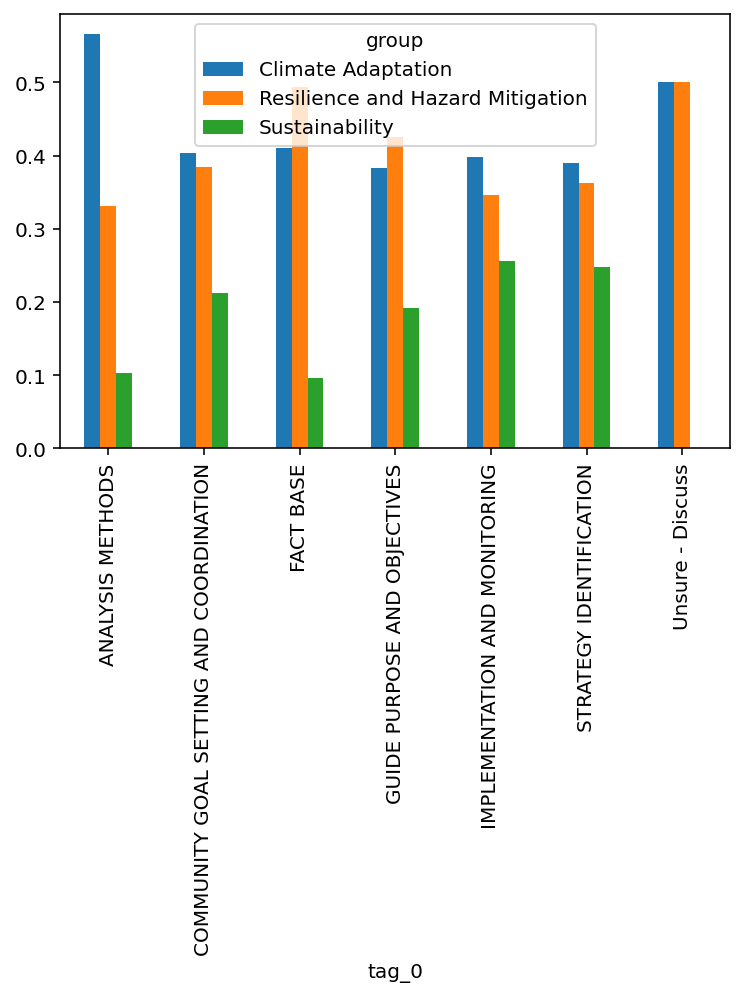

In [12]:
# plotting tags by group (RAS label)
# for percent labels on bars:
# https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

df.groupby('tag_0')['group'].value_counts(normalize=True).unstack(fill_value=0).plot.bar()

## Preprocessing

In [13]:
# get list of snippets (the "documents"), labels ("RAS"), and source (the source guidance document)

raw = df['snippet'].apply(str).tolist()
text = df['snippet'].apply(str).tolist()
label = df['group'].apply(str).tolist()
source = df['source'].apply(str).tolist()
id = df['unique_id'].tolist()
# tag_0, tag_1, tag_2 = df['tag_0'].apply(str).tolist(), df['tag_1'].apply(str).tolist(), df['tag_2'].apply(str).tolist()

In [14]:
print("Example:\n")
print('Label: '+label[0])
print('Source: '+source[0])
print('Doc ID: '+str(id[0]))
print('Raw text: '+raw[0])

Example:

Label: Climate Adaptation
Source: A1 - Plan Alignment Compass_Combined
Doc ID: 2
Raw text: Quality public engagement is essential, and sometimes even required. Think of new ways to engage diverse stakeholders, especially from underserved areas. Meet at places that are special to the community and visitors. Always ask, Who is missing? Who should be involved?


In [15]:
# methods to preprocess docs

def preprocess_text(s):
    s = s.lower()
    # remove punctuation
    s = re.sub(r'[^\w]', ' ', re.sub(r'[^a-zA-Z0-9]', ' ', s))
    # remove numbers
    s = re.sub(r'\d+', ' ', s)
    return s

def tokenize_text(s, stop=stop_words, option='', tokens=False):
    t = word_tokenize(s)
    t = [word for word in t if word not in stop]
    if option == 'stemmed':
        t = [stemmer.stem(word) for word in t]
    elif option == 'lemmed':
        t = [WordNetLemmatizer().lemmatize(word) for word in t]
    
    if tokens:
        return t
    else:
        return " ".join(t)

def preprocess_docs(docs):
    docs = [preprocess_text(s) for s in docs]
    return docs

def tokenize_docs(docs, stop=stop_words, option='', tokens=False):
    docs = [tokenize_text(s, stop, option, tokens) for s in docs]
    return docs

def preprocess_and_tokenize(docs, stop=stop_words, option='', tokens=False):
    docs = tokenize_docs(preprocess_docs(docs), stop, option, tokens)
    return docs


In [16]:
# preprocessing
text = preprocess_docs(raw)
print('Example of preprocessing:')
print(text[0])

Example of preprocessing:
quality public engagement is essential  and sometimes even required  think of new ways to engage diverse stakeholders  especially from underserved areas  meet at places that are special to the community and visitors  always ask  who is missing  who should be involved 


In [17]:
# preprocessing and removing stop words
text_no_stop = tokenize_docs(text)
print('Example with stop word removal:')
print(text_no_stop[0])

Example with stop word removal:
quality public engagement essential sometimes even required think new ways engage diverse stakeholders especially underserved areas meet places special community visitors always ask missing involved


In [18]:
# lemmed and stemmed
text_lemmed = tokenize_docs(text, option='lemmed')
text_stemmed = tokenize_docs(text, option='stemmed')
print('Lemmed: '+text_lemmed[0])
print('Stemmed: '+text_stemmed[0])

Lemmed: quality public engagement essential sometimes even required think new way engage diverse stakeholder especially underserved area meet place special community visitor always ask missing involved
Stemmed: qualiti public engag essenti sometim even requir think new way engag divers stakehold especi underserv area meet place special commun visitor alway ask miss involv


In [19]:
# just the tokens
tokens = tokenize_docs(text, tokens=True)
tokens_lemmed = tokenize_docs(text, option='lemmed', tokens=True)
tokens_stemmed = tokenize_docs(text, option='stemmed', tokens=True)
print('Just the tokens:')
print(tokens[0])
print('Lemmed tokens:')
print(tokens_lemmed[0])
print('Stemmed tokens:')
print(tokens_stemmed[0])

Just the tokens:
['quality', 'public', 'engagement', 'essential', 'sometimes', 'even', 'required', 'think', 'new', 'ways', 'engage', 'diverse', 'stakeholders', 'especially', 'underserved', 'areas', 'meet', 'places', 'special', 'community', 'visitors', 'always', 'ask', 'missing', 'involved']
Lemmed tokens:
['quality', 'public', 'engagement', 'essential', 'sometimes', 'even', 'required', 'think', 'new', 'way', 'engage', 'diverse', 'stakeholder', 'especially', 'underserved', 'area', 'meet', 'place', 'special', 'community', 'visitor', 'always', 'ask', 'missing', 'involved']
Stemmed tokens:
['qualiti', 'public', 'engag', 'essenti', 'sometim', 'even', 'requir', 'think', 'new', 'way', 'engag', 'divers', 'stakehold', 'especi', 'underserv', 'area', 'meet', 'place', 'special', 'commun', 'visitor', 'alway', 'ask', 'miss', 'involv']


# Encodings

In [21]:
# method to perform encodings using sklearn
def get_encoding(docs, vec):
    mat = vec.fit_transform(docs)
    xmat = mat.toarray()
    names = vec.get_feature_names()
    df = pd.DataFrame(xmat, columns = names)
    return df, mat, xmat,names

## word counts / BoW

In [22]:
# count vectorizer with defaults
cv_default = CountVectorizer()

In [23]:
# try on preprocessed text (without stop word removal or lemmatization/stemming)
cv_df, _, _, _ = get_encoding(text, cv_default)
# results in ~ 10k features!
print(cv_df) 

      aa  aaas  ab  abag  abandoned  abandoning  abatement  abbreviated  \
0      0     0   0     0          0           0          0            0   
1      0     0   0     0          0           0          0            0   
2      0     0   0     0          0           0          0            0   
3      0     0   0     0          0           0          0            0   
4      0     0   0     0          0           0          0            0   
...   ..   ...  ..   ...        ...         ...        ...          ...   
2861   0     0   0     0          0           0          0            0   
2862   0     0   0     0          0           0          0            0   
2863   0     0   0     0          0           0          0            0   
2864   0     0   0     0          0           0          0            0   
2865   0     0   0     0          0           0          0            0   

      abilities  ability  ...  zero  zip  zone  zoned  zones  zonesa  \
0             0        0  .

In [24]:
# count vectorizer with min/max document frequencies and stop word removal
cv_lim = CountVectorizer(min_df=0.05, max_df=0.95, stop_words='english')

In [25]:
cv_df, _, _, _ = get_encoding(text, cv_lim)
# results in ~ 150 features
print(cv_df)

      action  actions  activities  adaptation  additional  address  agencies  \
0          0        0           0           0           0        0         0   
1          0        0           0           0           0        0         0   
2          0        0           0           0           0        0         0   
3          0        0           0           0           0        0         0   
4          0        0           0           0           0        0         0   
...      ...      ...         ...         ...         ...      ...       ...   
2861       0        0           0           0           1        1         0   
2862       0        0           0           0           0        0         0   
2863       0        0           0           0           0        0         0   
2864       0        0           0           0           0        0         0   
2865       0        0           0           0           0        0         0   

      analysis  approach  appropriate  

In [26]:
# use text_lemmed to reduce duplicate features (eg, action and actions)
cv_df, _, _, _ = get_encoding(text_lemmed, cv_lim)
# results in ~ 170 features
print(cv_df)

      action  activity  adaptation  additional  address  affect  agency  \
0          0         0           0           0        0       0       0   
1          0         0           0           0        0       0       1   
2          0         0           0           0        0       0       0   
3          0         0           0           0        0       0       0   
4          0         0           0           0        0       0       0   
...      ...       ...         ...         ...      ...     ...     ...   
2861       0         0           0           1        1       0       0   
2862       0         0           0           0        0       0       0   
2863       0         0           0           0        0       0       0   
2864       0         0           0           0        0       0       0   
2865       0         0           0           0        0       0       0   

      analysis  approach  appropriate  ...  use  used  using  utility  value  \
0            0     

In [27]:
# count most common words
cv_df.sum().sort_values(ascending=False).head(10)

community    3162
plan         2951
planning     2553
climate      1617
hazard       1495
local        1490
change       1438
action       1398
risk         1323
process      1234
dtype: int64

## tf-idf

In [28]:
# tf-idf using defaults
tfidf_default = TfidfVectorizer()

In [29]:
# preprocessed text
tfidf_df, _, _, _ = get_encoding(text, tfidf_default)
# again ~ 10k features
print(tfidf_df)

       aa  aaas   ab  abag  abandoned  abandoning  abatement  abbreviated  \
0     0.0   0.0  0.0   0.0        0.0         0.0        0.0          0.0   
1     0.0   0.0  0.0   0.0        0.0         0.0        0.0          0.0   
2     0.0   0.0  0.0   0.0        0.0         0.0        0.0          0.0   
3     0.0   0.0  0.0   0.0        0.0         0.0        0.0          0.0   
4     0.0   0.0  0.0   0.0        0.0         0.0        0.0          0.0   
...   ...   ...  ...   ...        ...         ...        ...          ...   
2861  0.0   0.0  0.0   0.0        0.0         0.0        0.0          0.0   
2862  0.0   0.0  0.0   0.0        0.0         0.0        0.0          0.0   
2863  0.0   0.0  0.0   0.0        0.0         0.0        0.0          0.0   
2864  0.0   0.0  0.0   0.0        0.0         0.0        0.0          0.0   
2865  0.0   0.0  0.0   0.0        0.0         0.0        0.0          0.0   

      abilities  ability  ...  zero  zip  zone  zoned  zones  zonesa  \
0  

In [30]:
# lemmed version
tfidf_df, _, _, _ = get_encoding(text_lemmed, tfidf_default)
# ~ 9k features!
print(tfidf_df)

       aa  aaa   ab  abag  abandoned  abandoning  abatement  abbreviated  \
0     0.0  0.0  0.0   0.0        0.0         0.0        0.0          0.0   
1     0.0  0.0  0.0   0.0        0.0         0.0        0.0          0.0   
2     0.0  0.0  0.0   0.0        0.0         0.0        0.0          0.0   
3     0.0  0.0  0.0   0.0        0.0         0.0        0.0          0.0   
4     0.0  0.0  0.0   0.0        0.0         0.0        0.0          0.0   
...   ...  ...  ...   ...        ...         ...        ...          ...   
2861  0.0  0.0  0.0   0.0        0.0         0.0        0.0          0.0   
2862  0.0  0.0  0.0   0.0        0.0         0.0        0.0          0.0   
2863  0.0  0.0  0.0   0.0        0.0         0.0        0.0          0.0   
2864  0.0  0.0  0.0   0.0        0.0         0.0        0.0          0.0   
2865  0.0  0.0  0.0   0.0        0.0         0.0        0.0          0.0   

      ability  able  ...  zebra  zero  zip  zone  zoned  zonesa  \
0         0.0   0.0 

In [31]:
# let's try min/max df
tfidf_lim = TfidfVectorizer(min_df=0.025, max_df=0.975, stop_words='english')

In [32]:
tstem_df, tstem_mat, tstem_xmat, tstem_names = get_encoding(text_stemmed, tfidf_lim)
# ~ 400 features
print(tstem_df)

      abil  abl  access   account    achiev  act  action  activ  adapt  \
0      0.0  0.0     0.0  0.000000  0.000000  0.0     0.0    0.0    0.0   
1      0.0  0.0     0.0  0.000000  0.000000  0.0     0.0    0.0    0.0   
2      0.0  0.0     0.0  0.000000  0.000000  0.0     0.0    0.0    0.0   
3      0.0  0.0     0.0  0.000000  0.000000  0.0     0.0    0.0    0.0   
4      0.0  0.0     0.0  0.000000  0.000000  0.0     0.0    0.0    0.0   
...    ...  ...     ...       ...       ...  ...     ...    ...    ...   
2861   0.0  0.0     0.0  0.000000  0.000000  0.0     0.0    0.0    0.0   
2862   0.0  0.0     0.0  0.000000  0.000000  0.0     0.0    0.0    0.0   
2863   0.0  0.0     0.0  0.000000  0.000000  0.0     0.0    0.0    0.0   
2864   0.0  0.0     0.0  0.000000  0.404709  0.0     0.0    0.0    0.0   
2865   0.0  0.0     0.0  0.164999  0.000000  0.0     0.0    0.0    0.0   

         addit  ...  vari  varieti  variou  vulner  want  water       way  \
0     0.000000  ...   0.0      0.0

In [33]:
t2_df, t2_mat, t2_xmat, t2_names = get_encoding(text_lemmed, tfidf_lim)
# ~ 170 features
print(t2_df)

      ability  able  access  achieve  action  activity  adaptation  addition  \
0         0.0   0.0     0.0      0.0     0.0       0.0         0.0       0.0   
1         0.0   0.0     0.0      0.0     0.0       0.0         0.0       0.0   
2         0.0   0.0     0.0      0.0     0.0       0.0         0.0       0.0   
3         0.0   0.0     0.0      0.0     0.0       0.0         0.0       0.0   
4         0.0   0.0     0.0      0.0     0.0       0.0         0.0       0.0   
...       ...   ...     ...      ...     ...       ...         ...       ...   
2861      0.0   0.0     0.0      0.0     0.0       0.0         0.0       0.0   
2862      0.0   0.0     0.0      0.0     0.0       0.0         0.0       0.0   
2863      0.0   0.0     0.0      0.0     0.0       0.0         0.0       0.0   
2864      0.0   0.0     0.0      0.0     0.0       0.0         0.0       0.0   
2865      0.0   0.0     0.0      0.0     0.0       0.0         0.0       0.0   

      additional   address  ...  vulner

In [34]:
# inspect top words in a doc (snippet)
z = t2_df.iloc[0]
print(z.sort_values(ascending=False).head(10))

essential     0.315933
special       0.313369
quality       0.295058
engage        0.293784
required      0.291304
engagement    0.280091
meet          0.276562
involved      0.274624
place         0.266519
way           0.238904
Name: 0, dtype: float64


In [35]:
# inspect top words across docs (snippets); but note that tf-idf scores computed *per doc*
print(t2_df.sum().sort_values(ascending=False).head(10))

plan         169.922173
community    158.358368
planning     141.348319
climate      119.167799
hazard       102.270157
step          97.548296
change        96.900068
local         96.814435
action        95.853192
risk          85.662403
dtype: float64


### [TODO] Can extend all of the above to n-grams!

In [36]:
# tf-idf with ngrams
tfidf_sublinear_bigrams = TfidfVectorizer(
    analyzer='word',
    # n-gram range (note: unit is 'word')
    ngram_range=(1,2),
    # maximum document frequency
    max_df = 0.975,    
    # minimum document frequency cutoff
    min_df = 0.025,
    # TODO: remove stop words *before* tfidf
    stop_words = 'english',
    # Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
    sublinear_tf=True
)

# preprocessed text
tfidf_bi_df, _, _, _ = get_encoding(text_lemmed, tfidf_sublinear_bigrams)
print(tfidf_bi_df)

      ability  able  access  achieve  action  action plan  activity  \
0         0.0   0.0     0.0      0.0     0.0          0.0       0.0   
1         0.0   0.0     0.0      0.0     0.0          0.0       0.0   
2         0.0   0.0     0.0      0.0     0.0          0.0       0.0   
3         0.0   0.0     0.0      0.0     0.0          0.0       0.0   
4         0.0   0.0     0.0      0.0     0.0          0.0       0.0   
...       ...   ...     ...      ...     ...          ...       ...   
2861      0.0   0.0     0.0      0.0     0.0          0.0       0.0   
2862      0.0   0.0     0.0      0.0     0.0          0.0       0.0   
2863      0.0   0.0     0.0      0.0     0.0          0.0       0.0   
2864      0.0   0.0     0.0      0.0     0.0          0.0       0.0   
2865      0.0   0.0     0.0      0.0     0.0          0.0       0.0   

      adaptation  adaptation plan  adaptation planning  ...  \
0            0.0              0.0                  0.0  ...   
1            0.0     

In [37]:
# get tfidf scores (and sort) for a given doc
def get_tfidf(text, tv, sort=True):
    f_matrix= tv.transform([text]).todense()
    f_index = f_matrix[0,:].nonzero()[1]
    tfidf_scores = zip([tv.get_feature_names()[i] for i in f_index], [f_matrix[0, x] for x in f_index])
    if sort:
        tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    return dict(tfidf_scores)

In [38]:
# shown on first doc
print('doc:')
print(text[0])
print('\n')
print('tf-idf scores:')
get_tfidf(text[0], tfidf_lim)

doc:
quality public engagement is essential  and sometimes even required  think of new ways to engage diverse stakeholders  especially from underserved areas  meet at places that are special to the community and visitors  always ask  who is missing  who should be involved 


tf-idf scores:


{'essential': 0.3545129975493558,
 'special': 0.3516352926479678,
 'quality': 0.33108911058123425,
 'engage': 0.3296592645875776,
 'required': 0.3268766399386307,
 'engagement': 0.31429448245128394,
 'meet': 0.310334154015216,
 'involved': 0.3081590953364492,
 'new': 0.25357658881489614,
 'public': 0.2203557377327104,
 'community': 0.15040449956207802}

In [39]:
# shown on new doc
new_text = 'This is a new sentence about resilience, adaptation, and sutainability planning that involves unique economic solutions.'
get_tfidf(new_text, tfidf_default)

{'sentence': 0.6246003793422709,
 'involves': 0.409469222369665,
 'unique': 0.4043421952872366,
 'economic': 0.2656717555042802,
 'new': 0.2609066486262541,
 'resilience': 0.24296247430876475,
 'adaptation': 0.2327898566938,
 'planning': 0.16383244152457957}

In [40]:
# top n terms per doc
n = 10

def top_n_terms(tfidf, tfidf_df, xmat, n=10):
    vocab = tfidf.vocabulary_
    reverse_vocab = {v:k for k,v in vocab.items()}
    idx = xmat.argsort(axis=1)
    tfidf_max = idx[:,-n:]
    tfidf_df['top'+str(n)] = [[reverse_vocab.get(item) for item in row] for row in tfidf_max ]
    print(tfidf_df['top'+str(n)])
    
top_n_terms(tfidf_lim, t2_df, t2_xmat)    

0       [way, place, involved, meet, engagement, requi...
1       [flooding, floodplain, flood, planning, plan, ...
2       [flood, financial, figure, fema, form, zoning,...
3       [flood, financial, figure, fema, federal, form...
4       [make, outreach, community, sector, relevant, ...
                              ...                        
2861    [different, jurisdiction, necessary, developed...
2862    [measure, official, update, monitoring, electe...
2863    [operation, report, growth, external, implemen...
2864    [stakeholder, key, measure, list, outreach, cr...
2865    [progress, large, representative, continue, st...
Name: top10, Length: 2866, dtype: object


In [41]:
# top n terms across docs (but meaningless since tf-idf is computed for each doc!)

feature_array = np.array(t2_names)
tfidf_sorting = np.argsort(t2_xmat).flatten()[::-1]

top_n = feature_array[tfidf_sorting][:n]
print(top_n)

['board' 'sustainability' 'meet' 'key' 'group' 'stakeholder' 'continue'
 'representative' 'large' 'progress']


## BoW / tf-idf with gensim

In [42]:
# tf-idf BoW with gensim

# source: https://ithaka.github.io/tdm-notebooks/finding-significant-terms.html
import gensim

dictionary = gensim.corpora.Dictionary(tokens_lemmed)
print(dictionary)

Dictionary(8809 unique tokens: ['always', 'area', 'ask', 'community', 'diverse']...)


In [43]:
# list(dictionary.token2id.items())
dictionary.token2id.get('resilience', 0) 

1718

In [44]:
bow_corpus = [dictionary.doc2bow(doc) for doc in tokens_lemmed]

print('Bag of words corpus created successfully.')

list(bow_corpus[0][:10]) # List out a slice of the first ten items

Bag of words corpus created successfully.


[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

In [45]:
word_counts = [[(dictionary[id], count) for id, count in line] for line in bow_corpus]
list(word_counts[0][:10])

[('always', 1),
 ('area', 1),
 ('ask', 1),
 ('community', 1),
 ('diverse', 1),
 ('engage', 1),
 ('engagement', 1),
 ('especially', 1),
 ('essential', 1),
 ('even', 1)]

In [46]:
model = gensim.models.TfidfModel(bow_corpus) 

In [47]:
# Create TF-IDF scores for the ``bow_corpus`` using our model
corpus_tfidf = model[bow_corpus]

# List out the TF-IDF scores for the first 10 tokens of the first text in the corpus
list(corpus_tfidf[0][:10])

[(0, 0.26779693729986226),
 (1, 0.09374873518685997),
 (2, 0.2290783857940376),
 (3, 0.051162899538239735),
 (4, 0.20944696895426534),
 (5, 0.1768366347835808),
 (6, 0.16601294023209476),
 (7, 0.20677182926660803),
 (8, 0.1943891361809766),
 (9, 0.1903919304476003)]

In [48]:
example_tfidf_scores = [[(dictionary[id], count) for id, count in line] for line in corpus_tfidf]

# List out the TF-IDF scores for the first 10 tokens of the first text in the corpus
list(example_tfidf_scores[0][:10]) 

[('always', 0.26779693729986226),
 ('area', 0.09374873518685997),
 ('ask', 0.2290783857940376),
 ('community', 0.051162899538239735),
 ('diverse', 0.20944696895426534),
 ('engage', 0.1768366347835808),
 ('engagement', 0.16601294023209476),
 ('especially', 0.20677182926660803),
 ('essential', 0.1943891361809766),
 ('even', 0.1903919304476003)]

In [49]:
# Sort the tuples in our tf-idf scores list

# Choosing a document by its index number
# Change n to see a different document
n = 0

def Sort(tfidf_tuples): 
    tfidf_tuples.sort(key = lambda x: x[1], reverse=True) 
    return tfidf_tuples 

# Print the document id and title
print('Label: ', label[n])
print('ID: ', str(id[n]))
print('Source: ', source[n])

#List the top twenty tokens in our example document by their TF-IDF scores
list(Sort(example_tfidf_scores[n])[:20]) 

Label:  Climate Adaptation
ID:  2
Source:  A1 - Plan Alignment Compass_Combined


[('missing', 0.37012302530506147),
 ('visitor', 0.3051836286865956),
 ('always', 0.26779693729986226),
 ('underserved', 0.26779693729986226),
 ('sometimes', 0.265165313221067),
 ('ask', 0.2290783857940376),
 ('diverse', 0.20944696895426534),
 ('especially', 0.20677182926660803),
 ('think', 0.20505938085866843),
 ('essential', 0.1943891361809766),
 ('special', 0.19235351368304052),
 ('even', 0.1903919304476003),
 ('quality', 0.17784484346982343),
 ('engage', 0.1768366347835808),
 ('required', 0.17487505154814062),
 ('engagement', 0.16601294023209476),
 ('meet', 0.1632258762928143),
 ('involved', 0.1616956291422169),
 ('place', 0.15530080227520263),
 ('way', 0.13354277758806563)]

In [50]:
# Define a dictionary ``td`` where each document gather
td = { 
dictionary.get(_id): value for doc in corpus_tfidf
for _id, value in doc
}

# Sort the items of ``td`` into a new variable ``sorted_td``
# the ``reverse`` starts from highest to lowest
sorted_td = sorted(td.items(), key=lambda kv: kv[1], reverse=True) 

for term, weight in sorted_td[:25]: # Print the top 25 terms in the entire corpus
    print(term, weight)

crosswalk 1.0
introduction 1.0
canvis 1.0
communityviz 1.0
weadapt 1.0
glossary 1.0
explorer 0.9716609147353716
opportunistic 0.9651460289258307
iso 0.9221366335975234
proposition 0.9218173514897314
afinding 0.9028735052724715
bselecting 0.9028735052724715
proces 0.8976147874958997
secure 0.8912941622148162
coa 0.8902466907199582
glance 0.8879024116068281
georgetown 0.8851817516134685
lan 0.8824433929667126
overview 0.8651434851880118
dashboard 0.8533295010601306
fx 0.8520849802446588
x 0.8433317631941925
assemble 0.8393374627112076
ix 0.8349445915760325
wildfre 0.8189178324868306


In [51]:
# For each document, print the ID, most significant/unique word, and TF/IDF score

n = 0

for n, doc in enumerate(corpus_tfidf):
    if len(doc) < 1:
        continue
    word_id, score = max(doc, key=lambda x: x[1])
    print(str(id[n]), dictionary.get(word_id), score)
    if n >= 10:
        break

2 missing 0.37012302530506147
3 captain 0.4467968336333995
4 reected 0.6479206752134844
5 eager 0.5974720600713433
6 unied 0.4379412840706839
7 crosswalk 1.0
8 crosswalk 1.0
9 consistent 0.4291503852811507
10 multiple 0.40850293009494865
11 silo 0.3330490374364895
12 reference 0.33546888077666204


In [52]:
from collections import defaultdict
terms_to_docs = defaultdict(list)
for doc_id, doc in enumerate(corpus_tfidf):
    for term_id, value in doc:
        term = dictionary.get(term_id)
        terms_to_docs[term].append((doc_id, value))
    if doc_id >= 500:
        break

In [53]:
# Pick a unigram to discover its score across documents
search_term = 'extreme'

# Display a list of documents and scores for the search term
matching = terms_to_docs.get(search_term)
for doc_id, score in sorted(matching, key=lambda x: x[1], reverse=True):
    print('ID: ', str(id[doc_id]), 'Score: ', score)

ID:  298 Score:  0.17035057607091467
ID:  210 Score:  0.1536123222556192
ID:  205 Score:  0.11744791620786717
ID:  206 Score:  0.11744791620786717
ID:  242 Score:  0.11319222762717313
ID:  305 Score:  0.10836489059450034
ID:  224 Score:  0.09970895075456754
ID:  171 Score:  0.08741439382459201
ID:  405 Score:  0.08575464427594766
ID:  406 Score:  0.08575464427594766
ID:  173 Score:  0.08007215047853417
ID:  343 Score:  0.07938716265826123
ID:  228 Score:  0.0668982508725307
ID:  164 Score:  0.04309714584905919
ID:  277 Score:  0.03311547518487095
ID:  278 Score:  0.03311547518487095
ID:  472 Score:  0.01660118192750627


## doc similarity

In [54]:
from sklearn.metrics.pairwise import cosine_similarity

# compute and print the cosine similarity matrix
cosine_sim = cosine_similarity(t2_mat, t2_mat)
# sim_df = pd.DataFrame(cosine_sim, columns=tfidf_names)
print(cosine_sim)

[[1.         0.         0.         ... 0.03970853 0.11403609 0.15217675]
 [0.         1.         0.07660793 ... 0.03353051 0.         0.06716772]
 [0.         0.07660793 1.         ... 0.         0.         0.02359774]
 ...
 [0.03970853 0.03353051 0.         ... 1.         0.24230318 0.14653467]
 [0.11403609 0.         0.         ... 0.24230318 1.         0.24663701]
 [0.15217675 0.06716772 0.02359774 ... 0.14653467 0.24663701 1.        ]]


# Classification

Let's use the RAS ('group') labels for classification. 

This is for simplicity. We can apply the same methods to classification of the tags or source document. 

In [55]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split

# list of unique labels
unique_labels = ['Climate Adaptation', 'Resilience and Hazard Mitigation', 'Sustainability']
# better:
# unique_labels = list(set(label))

In [56]:
# Train and test sets

# Create a series to store the labels: y
y = label

# Create training set and test set
X_train, X_test, y_train, y_test = train_test_split(text, y, 
                                                    test_size=0.33, random_state=53)

In [57]:
# train model on count features
# Transform the training data using only the 'text' column values: count_train
count_train = cv_lim.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test
count_test = cv_lim.transform(X_test)

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm =confusion_matrix(y_test, pred, labels=unique_labels)
print(cm)

0.7494714587737844
[[322  41  13]
 [ 87 276  37]
 [ 38  21 111]]


In [58]:
# train model on tfidf features
# Transform the training data: tfidf_train
tfidf_train = tfidf_lim.fit_transform(X_train)

# transform the test data: tfidf_test
tfidf_test = tfidf_lim.transform(X_test)

nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print("The accuracy of the classifier on the test set is %.3f" % score)

# Calculate the confusion matrix: cm
cm = confusion_matrix(y_test, pred, labels=unique_labels)
print(cm)

The accuracy of the classifier on the test set is 0.774
[[328  43   5]
 [ 85 307   8]
 [ 39  34  97]]


In [59]:
prediction = nb_classifier.predict(tfidf_lim.transform([new_text]))[0]
print("The label predicted by the classifier is: " + str(prediction))

The label predicted by the classifier is: Climate Adaptation


In [60]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
# import seaborn as sns

# only works for two labels
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','yellow']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

#fig = plt.figure(figsize=(16, 16))          
#plot_LSA(tfidf_train, y_train)
#plt.show()

In [61]:
# some hyperparameter tuning
alphas = np.arange(0, 1, 0.1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    
    # Fit to the training data
    nb_classifier.fit(tfidf_train, y_train)
    
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    
    # Compute accuracy: score
    score = accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0
Score:  0.7822410147991543

Alpha:  0.1
Score:  0.7801268498942917

Alpha:  0.2
Score:  0.7822410147991543

Alpha:  0.30000000000000004
Score:  0.7832980972515856

Alpha:  0.4
Score:  0.7822410147991543

Alpha:  0.5
Score:  0.7801268498942917

Alpha:  0.6000000000000001
Score:  0.7790697674418605

Alpha:  0.7000000000000001
Score:  0.7790697674418605

Alpha:  0.8
Score:  0.7758985200845666

Alpha:  0.9
Score:  0.7748414376321353



/Users/jff/miniconda/envs/nlp/lib/python3.7/site-packages/sklearn/naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [62]:
# inspect model
class_labels = nb_classifier.classes_

# Extract the features: feature_names
feature_names = tfidf_lim.get_feature_names()

# Zip the feature names together with the coefficient array 
# and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
print(class_labels[0], feat_with_weights[:20])

# Print the second class label and the bottom 20 feat_with_weights entries
print(class_labels[1], feat_with_weights[-20:])

Climate Adaptation [(-7.7630114582163285, 'integration'), (-7.597246595537091, 'jurisdiction'), (-7.550086971481929, 'sustainability'), (-7.527678468323507, 'improvements'), (-7.520604559246813, 'performance'), (-7.472084851134711, 'provided'), (-7.450338248319816, 'post'), (-7.402786075204491, 'task'), (-7.371341656207133, 'extent'), (-7.36301085498885, 'investments'), (-7.353669025209784, 'pre'), (-7.3491163576674765, 'promote'), (-7.211254881469023, 'recovery'), (-7.172923571390198, 'achieve'), (-7.128050128451128, 'functions'), (-7.1068855470700605, 'parks'), (-7.092695543545215, 'funds'), (-7.0879927446751045, 'establish'), (-7.046542969331248, 'partnerships'), (-7.026214222368652, 'reduction')]
Resilience and Hazard Mitigation [(-5.147947364930846, 'resilience'), (-5.121119353517468, 'resources'), (-4.999362382518914, 'team'), (-4.957949361100815, 'local'), (-4.95188655482038, 'step'), (-4.949746868493937, 'tribal'), (-4.9437786160644555, 'actions'), (-4.917948896987898, 'rise'),

### can extend classification to ngram models...

# Clustering

This can be useful for finding overlap across documents

In [63]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [64]:
import matplotlib.cm as cm

In [65]:
# assume 3 clusters
clusters = MiniBatchKMeans(n_clusters=3, init_size=1024, batch_size=2048, random_state=20).fit_predict(t2_mat)

Max label = 3


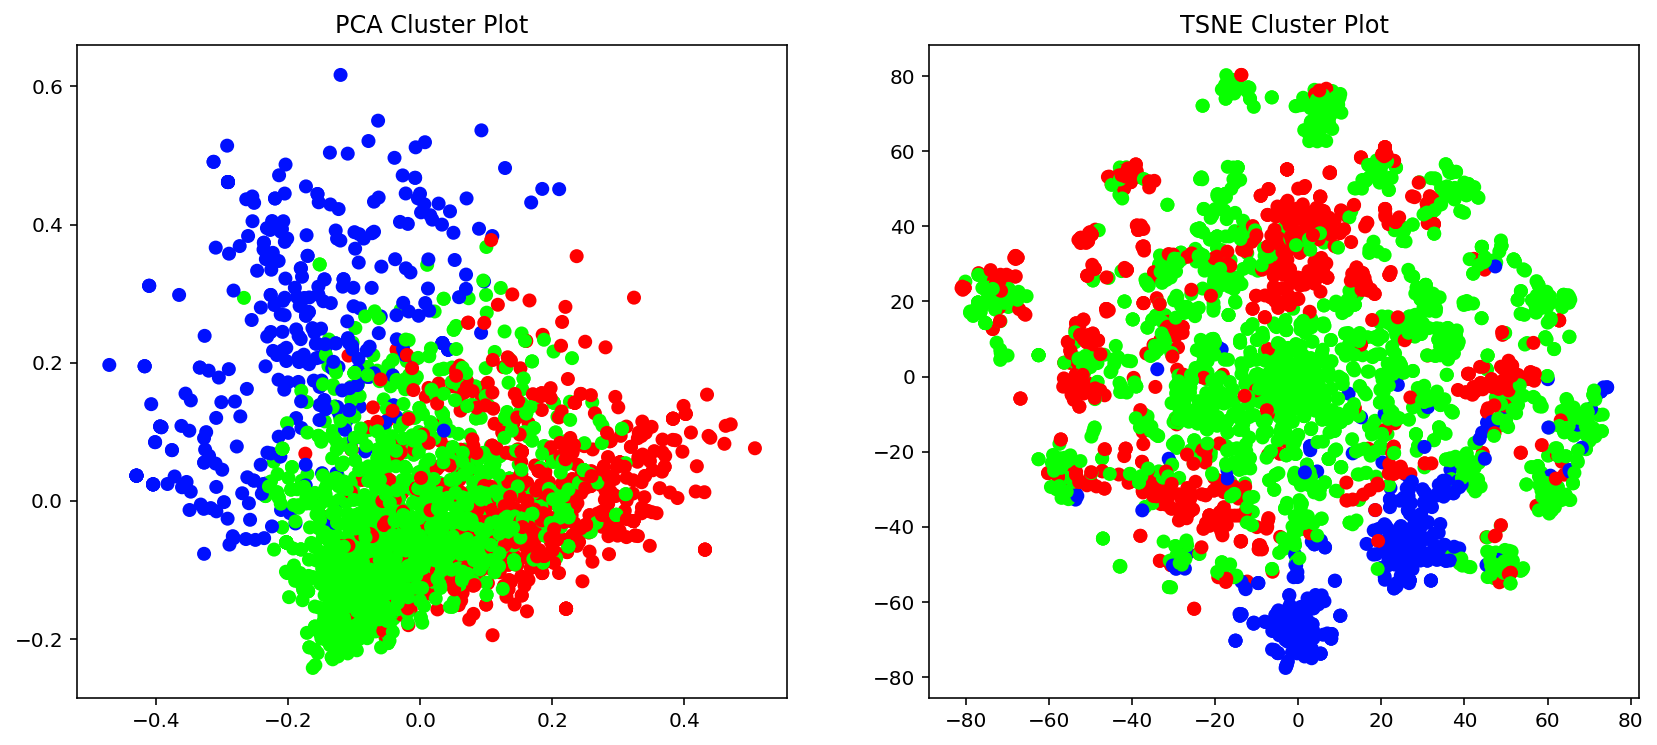

In [66]:
# plotting clusters via dimension reduction
def plot_tsne_pca(data, labels, k=3):
    # max_label = max(labels)
    max_label = k
    print('Max label = '+str(max_label))
    #max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    max_items = len(labels)
    
    pca = PCA(n_components=2).fit_transform(data.todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data.todense()))
        
    idx = np.random.choice(range(pca.shape[0]), size=100, replace=False)
    # label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in labels]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[:, 0], pca[:, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[:, 0], tsne[:, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
    
plot_tsne_pca(t2_mat, clusters)

In [67]:
# top keywords by cluster
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(t2_mat, clusters, t2_names, 10)


Cluster 0
area,resilience,action,local,development,mitigation,planning,community,hazard,plan

Cluster 1
local,sustainability,process,action,risk,assessment,team,planning,community,step

Cluster 2
community,planning,impact,coastal,adaptation,rise,level,sea,change,climate


In [68]:
# https://beckernick.github.io/law-clustering/

from sklearn.cluster import KMeans

kmeans_models = {}
for i in range(2,10+1):
    current_kmean = KMeans(n_clusters=i).fit(t2_mat)
    kmeans_models[i] = current_kmean
    
for i in range(2, 10+1):
    col_name = str(i) +'means_label'
    df[col_name] = kmeans_models[i].labels_

In [69]:
# let's focus on the k=3 cluster model

k = 3

km = kmeans_models[k]

clean_dict = dict(zip(label, text_lemmed))

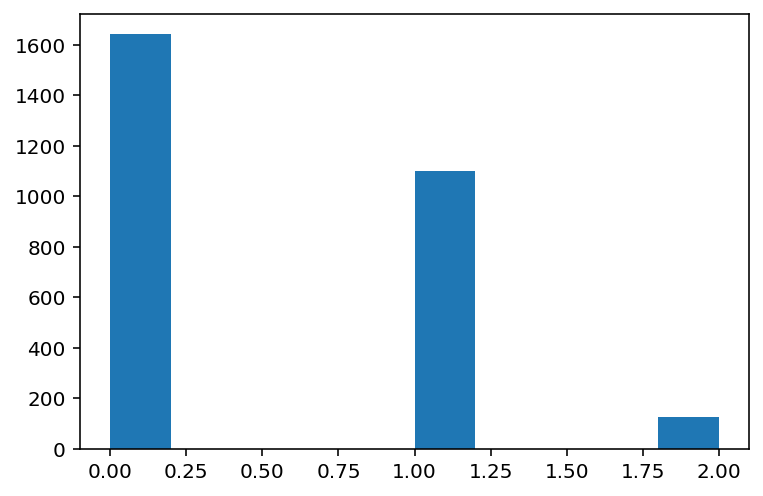

In [70]:
# cluster assignment distribution
plt.hist(km.labels_)
plt.show()

In [71]:
cluster_assignments_dict = {}

for i in set(km.labels_):
    print(i)
    current_cluster = [[v for index, (k, v) in enumerate(clean_dict.items())] for index in np.where(km.labels_ == i)[0]]
    cluster_assignments_dict[i] = current_cluster

0
1
2


In [72]:
cluster_assignments_dict = {}

for i in set(km.labels_):
    print('Cluster: {0}'.format(i))
    current_cluster = [text[index] for index in np.where(km.labels_ == i)[0]]
    cluster_assignments_dict[i] = current_cluster

Cluster: 0
Cluster: 1
Cluster: 2


In [73]:
# show docs by cluster assignment

cluster_pick = 0

print('Cluster: {0}'.format(cluster_pick))
cluster_assignments_dict[cluster_pick]

Cluster: 0


['quality public engagement is essential  and sometimes even required  think of new ways to engage diverse stakeholders  especially from underserved areas  meet at places that are special to the community and visitors  always ask  who is missing  who should be involved ',
 'equity and environmental justice must be considered at all times and reected in the planning budget',
 'reach out to scientists  they are often eager to provide insights on how climate information is effectively used  ',
 'the crosswalk',
 'the crosswalk',
 'coordinate plans with other cities and counties  and regionally  to identify risks and opportunities for integrated management',
 'if multiple modeling information sources are available  consider using them all to get a more robust assessment of the hazards  modeling results that overlap are a good indication that a particular area is especially vulnerable',
 'ensure that planning accounts for the useful life of critical infrastructure  not just design life  pla

In [74]:
# another dimension reduction technique for plotting

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [75]:
t2_reduced = TruncatedSVD(n_components=k, random_state=0).fit_transform(t2_mat)

In [76]:
t2_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(t2_reduced)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2866 samples in 0.001s...
[t-SNE] Computed neighbors for 2866 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2866
[t-SNE] Computed conditional probabilities for sample 2000 / 2866
[t-SNE] Computed conditional probabilities for sample 2866 / 2866
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.186s
[t-SNE] Iteration 50: error = 75.7647324, gradient norm = 0.0621861 (50 iterations in 0.958s)
[t-SNE] Iteration 100: error = 68.2650375, gradient norm = 0.0092507 (50 iterations in 0.763s)
[t-SNE] Iteration 150: error = 67.7206726, gradient norm = 0.0008511 (50 iterations in 0.698s)
[t-SNE] Iteration 200: error = 67.7027435, gradient norm = 0.0001246 (50 iterations in 0.702s)
[t-SNE] Iteration 250: error = 67.7019653, gradient norm = 0.0000730 (50 iterations in 0.625s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.701965
[t-SNE] Iteration 300: err

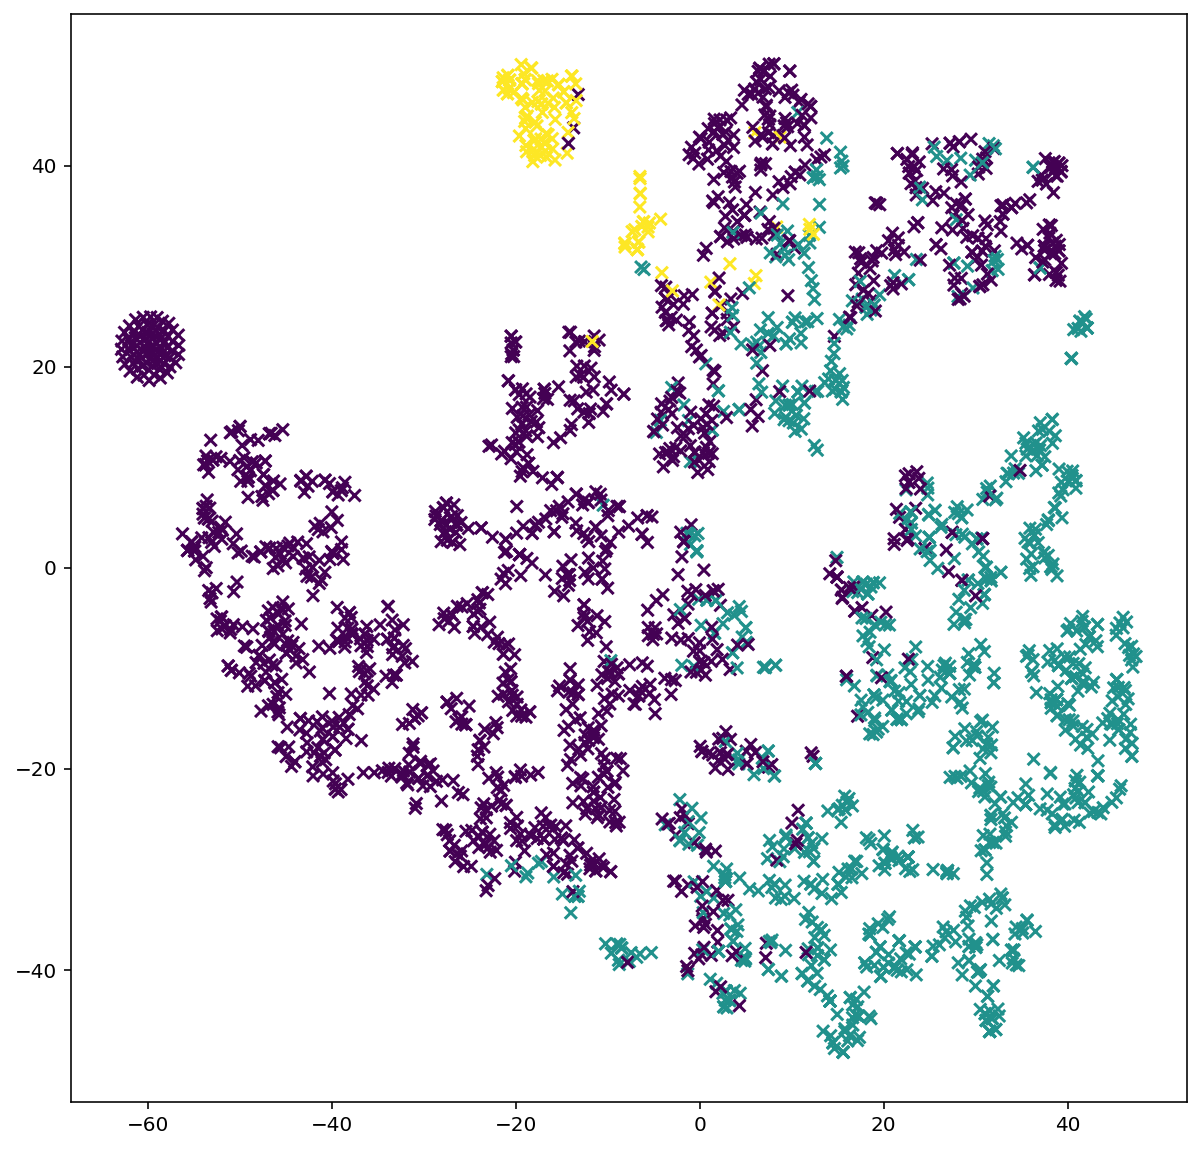

In [77]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(t2_embedded[:, 0], t2_embedded[:, 1], marker = "x", c = km.labels_)
plt.show()

In [78]:
# http://brandonrose.org/clustering

from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(t2_mat)
print(dist)

[[ 0.00000000e+00  1.00000000e+00  1.00000000e+00 ...  9.60291472e-01
   8.85963912e-01  8.47823251e-01]
 [ 1.00000000e+00 -2.22044605e-16  9.23392068e-01 ...  9.66469495e-01
   1.00000000e+00  9.32832280e-01]
 [ 1.00000000e+00  9.23392068e-01 -2.22044605e-16 ...  1.00000000e+00
   1.00000000e+00  9.76402265e-01]
 ...
 [ 9.60291472e-01  9.66469495e-01  1.00000000e+00 ... -2.22044605e-16
   7.57696824e-01  8.53465330e-01]
 [ 8.85963912e-01  1.00000000e+00  1.00000000e+00 ...  7.57696824e-01
  -4.44089210e-16  7.53362986e-01]
 [ 8.47823251e-01  9.32832280e-01  9.76402265e-01 ...  8.53465330e-01
   7.53362986e-01  0.00000000e+00]]


### k-means clustering and top terms

In [79]:
# kmeans for k=3 and stemmed tf-idf
kms = KMeans(n_clusters=k).fit(tstem_mat)

In [80]:
# use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_lemmed = []
totalvocab_tokenized = []
for i in text:
    allwords_stemmed = tokenize_text(i, tokens=True, option='stemmed') #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_lemmed = tokenize_text(i, tokens=True, option='lemmed') #for each item in 'synopses', tokenize/lem
    totalvocab_lemmed.extend(allwords_lemmed) #extend the 'totalvocab_lemmed' list
    
    allwords_tokenized = tokenize_text(i, tokens=True)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [81]:
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 205904 items in vocab_frame


In [82]:
clusters = kms.labels_.tolist()

docs_dict = { 'label': label, 'source': source, 'tag': df['tag_0'].apply(str).tolist(), 'cluster': clusters }

docs_df = pd.DataFrame(docs_dict, index = [clusters] , columns = ['label', 'source', 'tag', 'cluster'])

In [83]:
docs_df['cluster'].value_counts()

0    1687
2    1053
1     126
Name: cluster, dtype: int64

In [84]:
docs_df['label'].value_counts()

Climate Adaptation                  1207
Resilience and Hazard Mitigation    1111
Sustainability                       548
Name: label, dtype: int64

In [85]:
# now we can find top terms per cluster!

from __future__ import print_function

n_terms = 6

order_centroids = kms.cluster_centers_.argsort()[:, ::-1] 

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = kms.cluster_centers_.argsort()[:, ::-1] 

for i in range(k):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :n_terms]: #replace 6 with n words per cluster
        that = vocab_frame.loc[tstem_names[ind]].values.tolist()[0][0]
        print(' %s' % that, end=', ')
        # print(vocab_frame.loc[[tstem_names[i] for i in ind]].values.tolist())
        # print(*the_terms, sep=', ')
        #print(' %s' % , end=',')
       
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in docs_df[docs_df['cluster'] == i]['source'].unique():
        print(' %s,' % title[:2], end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: climate,  steps,  assessments,  change,  risk,  community, 

Cluster 0 titles: A1, A2, A3, A4, A5, A6, A7, A8, A9, R1, R1, R1, R2, R3, R4, R5, R6, R7, R8, R9, S1, S2, S3, S4, S5, S6,

Cluster 1 words: sea,  level,  rise,  coastal,  adaptation,  flooding, 

Cluster 1 titles: A1, A2, A3, A4, A5, A7, A8, A9, R9,

Cluster 2 words: plans,  community,  local,  developed,  actions,  mitigation, 

Cluster 2 titles: A1, A2, A3, A4, A5, A6, A7, A8, A9, R1, R1, R1, R2, R3, R4, R5, R6, R7, R8, S1, S2, S3, S4, S5, S6,





In [86]:
# check out the source docs per cluster
n = 0

docs_df[docs_df['cluster'] == n]['source'].unique()

array(['A1 - Plan Alignment Compass_Combined',
       'A2 - EPA 2014 risk based adaptation planning_workbook',
       'A3 - planning-framework-climate-resilient-economy-508_2',
       'A4 - FL 2018 Adaptation Planning Guidebook',
       'A5 - NOAA Coastal Management 2010 adaptationguide',
       'A6 - OCCRI 2018 tribal-climate-adaptation-guidebook',
       'A7 - CA-Adaptation-Planning-Guide-2020',
       'A8 - CA 2012 Adapting to Sea Level Rise',
       'A9 - USGCRP_Climate Resilience Toolkit',
       'R1 - Rockefeller CRI Compiled_01032021',
       'R10 - PIRS_Guidebook-2020.05-v5 (1)',
       'R11 - Community Resilience Building_Workshop Guide',
       'R2 - EPA 2019 regional_resilience_toolkit_Sept 2020',
       'R3 - fema_bric_nature-based-solutions_2020',
       'R4 - integrating_hazmit', 'R5 - fema_local_mitigation_handbook',
       'R6 - Plan_Integration_0812_508',
       'R7 - PreDisasterRecoveryGuideforLocalGov2017',
       'R8 - NIST.SP.1190GB-16',
       'R9 - NYC_Climate_Re

In [87]:
# plotting with MDS

import os  # for os.path.basename

import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()

In [88]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2', 
                 2: 'Cluster 3'}

In [89]:
# Single letter labels for RAS (probably a better way to do this)

ras = []

for i in label:
    if i == unique_labels[0]:
        ras_i = 'A'
    elif i == unique_labels[1]:
        ras_i = 'R'
    elif i == unique_labels[2]:
        ras_i = 'S'
    
    ras.append(ras_i)


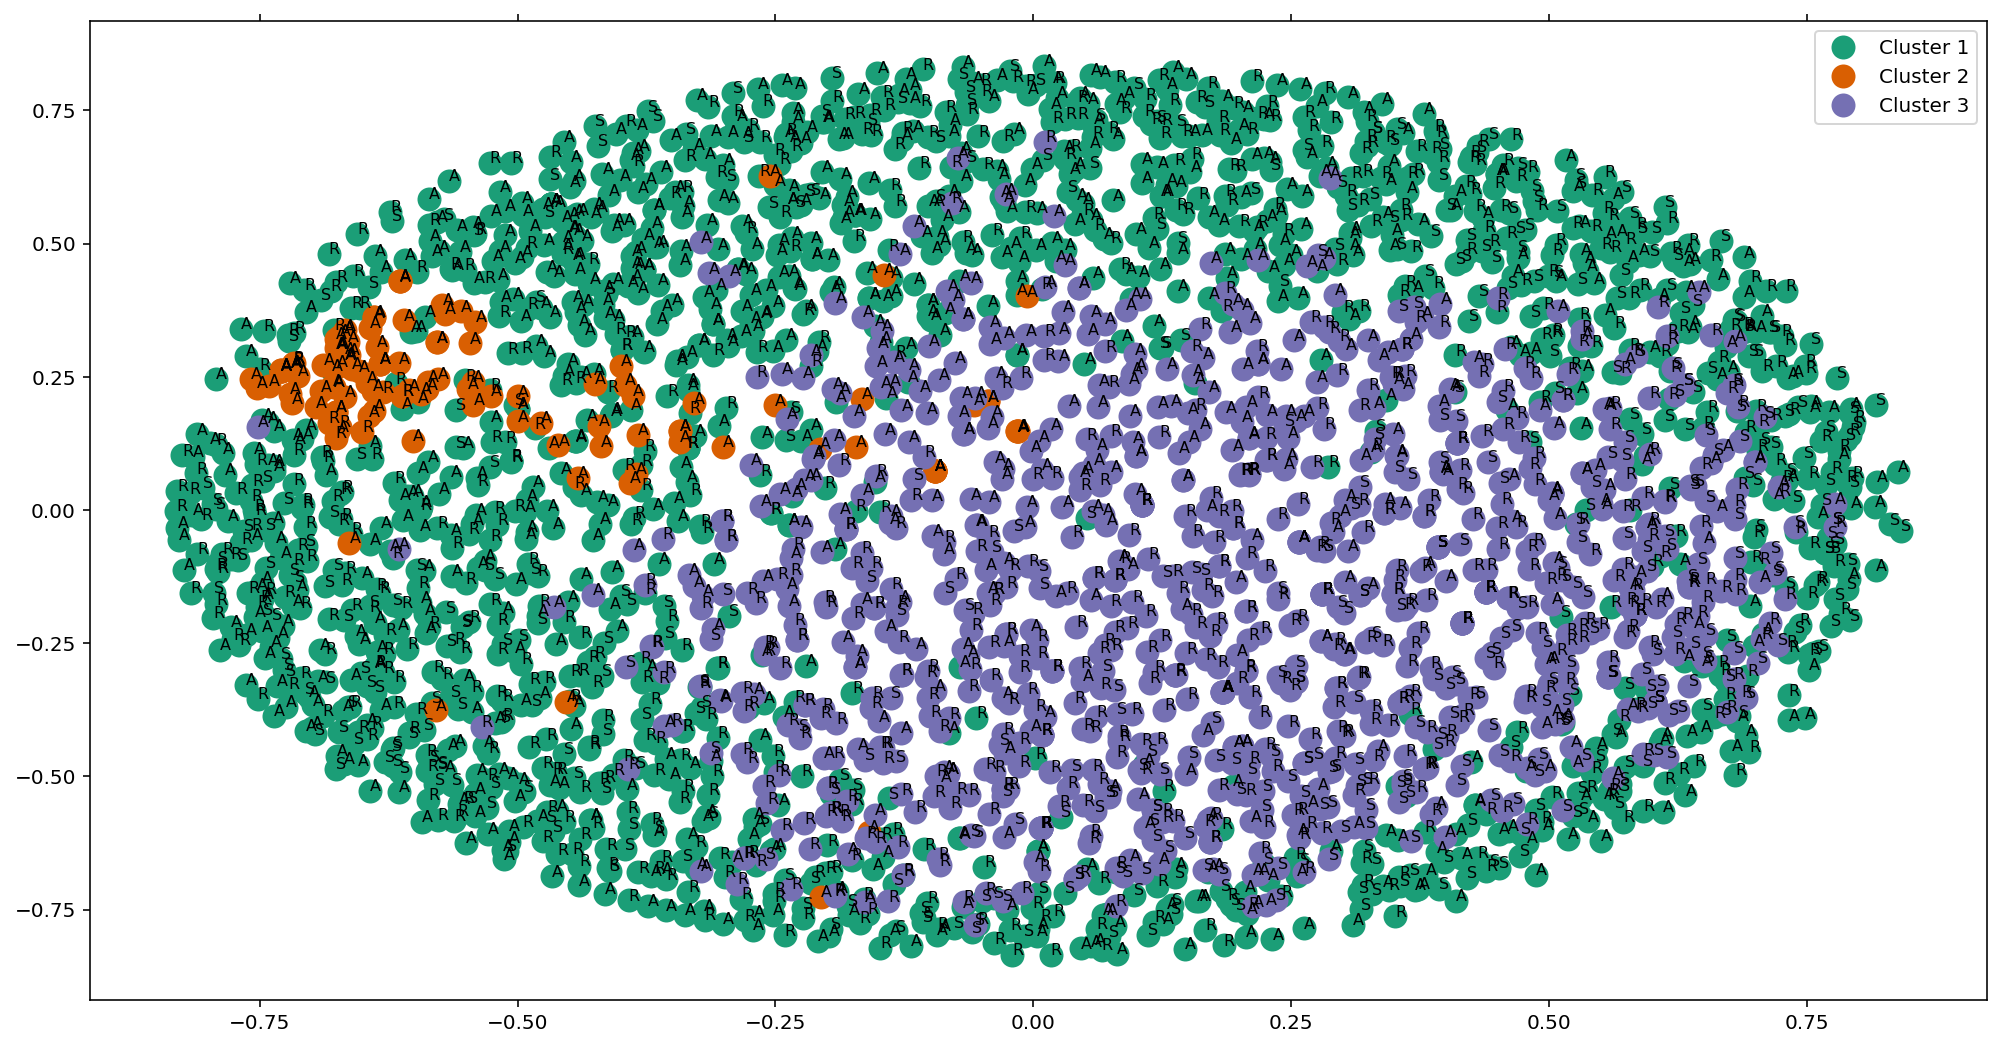

In [90]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df_mds = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=source, ras=ras)) 

#group by cluster
groups = df_mds.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df_mds)):
    ax.text(df_mds.iloc[i]['x'], df_mds.iloc[i]['y'], df_mds.iloc[i]['ras'], size=8)  

    
#uncomment the below to save the plot if need be
plt.savefig('../figs/kmneans_clusters_small_noaxes.png', dpi=200)
plt.show() #show the plot

